## Previous burden testing (without PCA filtering)

Initial burden tests were carried out on all available data. To try and improve the quality and relevance of the results, it is best if all samples being tested are from a homogeneous genetic background (**REF**), to ensure that you aren't inadvertantly detecting population differences rather than differences based on your trait of interest.

PCA was used to remove outliers and make sure that all samples were from a similar background. The samples were mapped to the 1kGP Phase 1 dataset, which includes ethnicity information. Outliers were removed to leave samples only mapping closely to the expected European population. ??? samples were removed.

Without this filtering, there were 249 cases and 588 control samples. Across these samples 18234 genes had at least one variant, of which a total of 284 with p <= 0.05 were detected by the burden test

The rest of this notebook is the same processing steps as 08_burden_testing, only using the PCA trimmed data.

## Initial data loading

The main dataset generated by previous processing is around 800Mb, so to facilitate sharing a trimmed version retaining only the relevant information. This reduces the total size of the saved data to 40Mb, which is much more practical.

The dataframe contains a row for each variant in each sample (e.g. variants in multiple patients occur multiple times - one per patient). Only those variants which occur in a maternal sample are retained, which further removes unnecessary data.

The columns for gene name, variant ID, mothers DDD ID, the variant count (1 for heterozygous, 2 for homozygous), and the pregnancy loss history are kept. Other data (including a large amount of phenotype information) are removed, but remain available in the full version of the dataset.

In [1]:
import pandas as pd
import scipy.stats as stats
import sys
#import sklearn.datasets
#import sklearn.decomposition
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#import pylab

%matplotlib inline
sns.set()

pd.options.display.max_columns = 999

In [2]:
# Load the smaller trimmed dataframe if it's available
try:
    df_joined = pd.read_pickle("Processed_data/Trimmed_variant_data.pickle")
    print("Loaded trimmed variant data from file", file=sys.stderr)
except FileNotFoundError:
    # Load the processed data from the previous step
    df_joined = pd.read_pickle('Data/variant_phenotype_merged.pickle')
    df_joined = df_joined[['GENE', 'ID', 'MAT_ID', 'MAT_COUNT', 'pregnancy_loss_history']]
    df_joined.to_pickle("Processed_data/Trimmed_variant_data.pickle")
    print("Loaded full data from file, and saved trimmed data", file=sys.stderr)

Loaded trimmed variant data from file


GENE            ID      MAT_ID  MAT_COUNT pregnancy_loss_history
0    AGRN   1:983604C>T  DDDP101785          1                      2
1  TAS1R3  1:1266738G>A  DDDP101785          1                      2
2  TAS1R3  1:1267651G>A  DDDP101785          2                      2
3  TAS1R3  1:1269488G>A  DDDP101785          1                      2
4    DVL1  1:1277183C>T  DDDP101785          1                      2

## Remove PCA-filtered samples

PCA analysis output a list of samples that are ok to use (e.g. are not outliers). Load this list, and filter to just those samples.

In [3]:
## TODO: Use the list of PCA-ok samples here before splitting to cases and controls
samples_to_keep = pd.read_csv("Data/PCA-samples-to-use.txt", names=["MAT_ID"])
# Convert to a list so it's really simple to iterate over
keep_list = samples_to_keep.MAT_ID.to_list()

# Now try to actually use this...
print(f"{samples_to_keep.shape[0]} samples to keep.", file=sys.stderr)
print(f"{len(df_joined.MAT_ID.unique())} samples before trimming.", file=sys.stderr)

# How many times does the first MAT IF occur?
df_joined = df_joined[df_joined['MAT_ID'].isin(keep_list)]

# Check that the samples have been dropped
print(f"{len(df_joined.MAT_ID.unique())} samples after PCA trimming.", file=sys.stderr)

1100 samples to keep.
1238 samples before trimming.
1100 samples after PCA trimming.


## splitting cases and controls

The DDD dataset reports numbers of prior miscarriages in 3 groups - "None", "2", and "3+". It is not clear what happens to women with a single previous miscarriages, but I assume these have been grouped with "None" as it is not indicative of recurre t pregnancy losses. 

To get the clearest possible differene between cases and the control group, the "2" pregnancy losses group is being discounted. The "None" group is used for controls, while the "3+" groups are the cases.

To record how many samples are in each group, the number of unique maternal IDs is counted. Larger numbers are better to provide more statistical power. It is probably not viable to use a public dataset such as GnomAD to boost the numbers of control samples, as this does not include the relevant information about previous pregnancy losses.

***Is there a good way of calculating the statistical power of a burden test based on the sample numbers?***

In [4]:
# Split cases and controls - use 3+ pregnancy losses as controls because 2 isn't as clearly recurrent
# TODO: Check to see how much difference this makes?
df_cases = df_joined[df_joined.pregnancy_loss_history == "3+"]
df_controls = df_joined[df_joined.pregnancy_loss_history == "None"]

ctrl_count = df_joined.drop_duplicates(['MAT_ID']).pregnancy_loss_history.value_counts()["None"]
case_count = df_joined.drop_duplicates(['MAT_ID']).pregnancy_loss_history.value_counts()["3+"]
discarded_count = df_joined.drop_duplicates(['MAT_ID']).pregnancy_loss_history.value_counts()["2"]

print(f"Total number of cases: {case_count}", file=sys.stderr)
print(f"Total number of controls: {ctrl_count}", file=sys.stderr)
print(f"Discarded samples: {discarded_count}", file=sys.stderr)

Total number of cases: 226
Total number of controls: 516
Discarded samples: 358


## Test running

[Guo et al (2018)](https://pubmed.ncbi.nlm.nih.gov/30269813/) suggests that burden testing follows these steps:

1. For each gene, count how many samples have at least 1 or 2 variants (depending on dominant or recessive model), and how many do not.
2. For each gene, make a confusion matrix of samples with and without variants for both controls and cases:

|          | >=n variants | <n variants |
|----------|--------------|-------------|
| Cases    |       a      |      b      |
| Controls |       c      |      d      |

3. Calculate Fishers exact to get a p-value for each gene
4. Identify those with a significant score (***??Does there need to be a correction applied??***)



Burden tests *may* have difficulties if some variants are non-causal (which seems to me to make them pretty much useless? Most variants are non-causal for the trait you're interested in) (https://www.uab.edu/medicine/rheumatology/images/09112014.pdf). SKAT test might be a better option? SKAT-O combines SKAT and burden tests.

In [5]:
def count_samples_with_variants(target_gene, dataframe):
    """Count how many samples in the given dataframe have at least 1 variant in the specified gene
    
    This can be modified to only count samples with variants matching particular modes of inheritence
    e.g. We can only count 
    """
    # subset the target dataframe to get only this gene
    temp_df = dataframe[dataframe.GENE == target_gene]
    # set MAT_COUNT == 2 and final == 1 to capture exclusively homozygous variants
    # set the final >= 1 to 2 (with MAT_COUNT >=1) to require at least a compound het, including hom
    # MAT_COUNT >=1 and .count == 1 should get single dominant variants
    # Currently, we are counting one or more variants
    temp_df_2 = temp_df[temp_df.MAT_COUNT >= 1].groupby("MAT_ID")[['MAT_COUNT']].count() >= 1
    
    # Return the number of samples in which the above criteria is matched
    answer = len(temp_df_2[temp_df_2.MAT_COUNT == True])
    
    # clear temp dataframes
    del(temp_df)
    del(temp_df_2)
    
    return answer


def do_burden_test(row):
    """Do a Fisher exact test on the case/control positive/negative counts"""
    cases = [row.loc['pos_cases'], row.loc['neg_cases']]
    controls = [row.loc['pos_controls'], row.loc['neg_controls']]
    # Use Scipy.stats fisher exact test
    # Order doesn't seem to matter as long as they are grouped correctly
    oddsratio, pvalue = stats.fisher_exact([cases, controls])
    
    if oddsratio < 1:
        # This will stop "protective" genes from appearing
        # They might be interesting, but they aren't relevant for now
        return 1
    return pvalue

In [6]:
%%time
try:
    burden_test = pd.read_pickle("Processed_data/burden_test_results.pickle")
except FileNotFoundError:
    burden_test = pd.DataFrame(columns=['GENE'])
    # get a list of all genes (need to cast to object type)
    burden_test['GENE'] = sorted(df_joined.GENE.astype("object").unique())

    # Have to use .insert() to add each column, otherwise I was getting a warning.
    burden_test.insert(1, "total_controls", df_controls.MAT_ID.unique().shape[0])
    burden_test.insert(2, "pos_controls", burden_test.GENE.apply(count_samples_with_variants, args=(df_controls,)))
    burden_test.insert(3, "neg_controls", burden_test["total_controls"] - burden_test["pos_controls"])
    burden_test.insert(4, "total_cases", df_cases.MAT_ID.unique().shape[0])
    burden_test.insert(5, "pos_cases", burden_test.GENE.apply(count_samples_with_variants, args=(df_cases,)))
    burden_test.insert(6, "neg_cases", burden_test["total_cases"] - burden_test["pos_cases"])

    burden_test.insert(7, 'pval', burden_test.apply(do_burden_test, axis=1))
    burden_test.to_pickle("Processed_data/burden_test_results.pickle")

print(f"Number of genes tested: {burden_test.shape[0]}", file=sys.stderr)

print(f"Genes with p <= 0.05: {burden_test[burden_test.pval <= 0.05].shape[0]}", file=sys.stderr)    

burden_test.sort_values('pval', ascending=True).head(25)

Wall time: 255 ms


Number of genes tested: 17794
Genes with p <= 0.05: 307


GENE  total_controls  pos_controls  neg_controls  total_cases  \
7385     INO80E             516             1           515          226   
5204    FAM186A             516            54           462          226   
12001     PRIM1             516             6           510          226   
10673    OR51J1             516             5           511          226   
6949   HSD17B13             516            50           466          226   
2965      CELF2             516             0           516          226   
7247     IGSF11             516             1           515          226   
4511       DUS2             516             1           515          226   
3799       CTU2             516            22           494          226   
3543      CPED1             516            23           493          226   
15144    TCF7L1             516            77           439          226   
7122      IFT80             516             3           513          226   
7557      ITPR2             516            48           468          226   
7997      KLK13             516            21           495          226   
13296    SAMD9L             516            61           455          226   
4674       EGFR             516             0           516          226   
1624     BPIFB3             516            12           504          226   
2466   CATSPER3             516            51           465          226   
10825     OR9Q1             516            33           483          226   
6502     GTF3C5             516            16           500          226   
13077       RPE             516             1           515          226   
2330     CACNB1             516             3           513          226   
2309      CABP2             516             3           513          226   
3860   CYB561D2             516             2           514          226   
3807      CUL4A             516             2           514          226   

       pos_cases  neg_cases      pval  
7385           9        217  0.000148  
5204          46        180  0.000431  
12001         13        213  0.000619  
10673         12        214  0.000664  
6949          43        183  0.000677  
2965           6        220  0.000762  
7247           7        219  0.001347  
4511           7        219  0.001347  
3799          24        202  0.001528  
3543          25        201  0.001713  
15144         56        170  0.001751  
7122           9        217  0.001755  
7557          40        186  0.001881  
7997          23        203  0.002055  
13296         47        179  0.002139  
4674           5        221  0.002541  
1624          16        210  0.002956  
2466          40        186  0.003527  
10825         30        196  0.003817  
6502          19        207  0.003944  
13077          6        220  0.003967  
2330           8        218  0.004481  
2309           8        218  0.004481  
3860           7        219  0.004489  
3807           7        219  0.004489

### More cases = better data?

It's possible that some of the genes above have significant results partly because they don't have a very large number of samples. To try and narrow down the results to only the most genuinely significant (without knowing right now if there are any appropriate corrections that can be done to the p value threshold) filter the results to only look at the genes where there are a good number of variants in both cases and controls.

Arbitrarily choose a minimum of 10 variants in both cases and controls, but it might be better just to limit by variants in cases? This would mean we don't lose extreme examples with very few variants in controls.

In [7]:
# To get a more reliable view, just use those genes were there are a higher number of positives (in cases and controls)
# This should help remove effects caused by low numbers of positive samples (perhaps small genes, etc.)
print(f"Genes with p <= 0.05 and at least 40 positives in cases: {burden_test[(burden_test.pos_cases >= 40) & (burden_test.pval < 0.05)].shape[0]}", file=sys.stderr)
burden_test[(burden_test.pos_cases >= 20) & (burden_test.pval <= 0.05)].sort_values('pval', ascending = True).head(25)

Genes with p <= 0.05 and at least 40 positives in cases: 42


GENE  total_controls  pos_controls  neg_controls  total_cases  \
5204    FAM186A             516            54           462          226   
6949   HSD17B13             516            50           466          226   
3799       CTU2             516            22           494          226   
3543      CPED1             516            23           493          226   
15144    TCF7L1             516            77           439          226   
7557      ITPR2             516            48           468          226   
7997      KLK13             516            21           495          226   
13296    SAMD9L             516            61           455          226   
2466   CATSPER3             516            51           465          226   
10825     OR9Q1             516            33           483          226   
12150     PRUNE             516            23           493          226   
8529       LRP2             516           146           370          226   
5138    FAM132B             516            50           466          226   
12142    PRSS55             516            31           485          226   
14175   SLCO4C1             516            45           471          226   
6104      GLIS2             516            47           469          226   
9211       MLPH             516            38           478          226   
13998   SLC34A1             516            34           482          226   
3287      CLOCK             516            51           465          226   
11975     PRDM5             516            31           485          226   
1460      BAZ2B             516            36           480          226   
7843   KIAA1456             516            59           457          226   
16331   TUBGCP6             516            93           423          226   
11607   PLEKHG1             516            67           449          226   
16342      TUT1             516            29           487          226   

       pos_cases  neg_cases      pval  
5204          46        180  0.000431  
6949          43        183  0.000677  
3799          24        202  0.001528  
3543          25        201  0.001713  
15144         56        170  0.001751  
7557          40        186  0.001881  
7997          23        203  0.002055  
13296         47        179  0.002139  
2466          40        186  0.003527  
10825         30        196  0.003817  
12150         23        203  0.004528  
8529          88        138  0.004631  
5138          39        187  0.004632  
12142         28        198  0.004735  
14175         36        190  0.004832  
6104          37        189  0.005447  
9211          32        194  0.005922  
13998         29        197  0.006465  
3287          39        187  0.006875  
11975         27        199  0.007317  
1460          30        196  0.007505  
7843          43        183  0.007527  
16331         61        165  0.007743  
11607         47        179  0.007925  
16342         26        200  0.008933

There are some interesting genes just in this top 25 list - RPE and PRIM1 are both imvovled in DNA replication - potentially a faulty maternal copy may affect extremely early embryo formation?

Are any of these significant genes present in Deborahs list of potentially important genes?

In [8]:
genes=["NLRP5","PADI6","NLRP14","DNMT1","TLE6","AKAP9","UHRF1","NLRP4","RDX","EEF1A1","ARHGEF2","NLRP7",
       "PYDC2","NLRP2","YWHAZ","DDB1","RHPN2","OOEP","USP9X","NLRP4","YWHAG","DDX6","YWHAH","YWHAQ","NLRP4",
       "YWHAE","DDX19A","DNMT1","ZAR1","DDX3X","DDX3Y","NLRP4","PDIA6","CDC42","CDCA2","CDK19","CDK5","MSN",
       "NLRP9"]

important_genes = burden_test[(burden_test.GENE.isin(genes)) & (burden_test.pval <= 0.05)]

important_genes

GENE  total_controls  pos_controls  neg_controls  total_cases  \
15399  TLE6             516             2           514          226   

       pos_cases  neg_cases      pval  
15399          6        220  0.011828

##TODO:

https://journals.plos.org/plosgenetics/article/file?id=10.1371/journal.pgen.1000384&type=printable

Burden test weighted by variant frequency - useful to try??

## Summarise data

TODO

In [9]:
significant_genes = burden_test[burden_test.pval <= 0.05]

significant_genes['total_pos'] = significant_genes['pos_cases'] + significant_genes['pos_controls']

<ipython-input-9-acd3508022ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_genes['total_pos'] = significant_genes['pos_cases'] + significant_genes['pos_controls']


## Histogram of number of variants

It is to be expected that the number of positive casees (e.g. those with variants) will scale largely in proportion to the overall number of variants detected.

The gene with the largest number of positive cases also has the largest number of positive controls. This gene was titin - an extremely large gene where we would expect to detect a large number of variants. We also would not expect titin to be a candidate gene, which is supported by the ratio of case and control variants closely matching the ratio of case and control numbers. The high p-value reflects this.

In most genes the case:control ratio is as expected. The purpose of the burden test is to identify those where the number of positive cases is higher than expected. Shading by the calculated p-value shows how p-value drops further as the number of cases increases from the expected values, and plotting only those genes with p <= 0.05 shows clearly the reduction in number.

C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Cases with varaints')

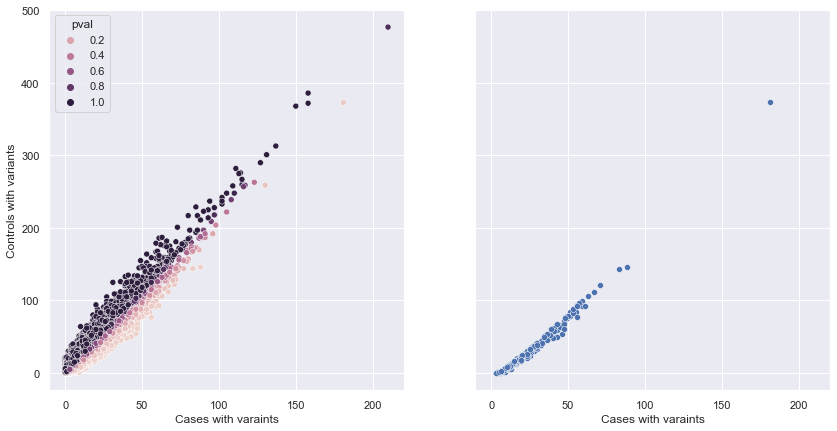

In [10]:
f, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)
ax1 = sns.scatterplot(burden_test.pos_cases, burden_test.pos_controls, hue=burden_test.pval, ax=axes[0])
ax1.set_ylabel("Controls with variants")
ax1.set_xlabel("Cases with varaints")
ax2 = sns.scatterplot(significant_genes.pos_cases, significant_genes.pos_controls, ax=axes[1])
ax2.set_ylabel("Controls with variants")
ax2.set_xlabel("Cases with varaints")

Where there are fewer variants overall, it is more difficult to be confident that an observed effect is true, even with a significant p-value. For example, if 3 cases and 1 control have a variant in a gene is that a true effect or just random? We do not have coverage information available, so we have to assume that a reference call at a position is from sufficient data, and is not actually missing because there was no coverage. This makes interpreting varaints with low varaint counts risky - as a single missed variant may be enough to change a result to significant.

The following histogram shows the distribution of the total number of variant samples (i.e. pos controls + pos cases) per gene. We can see that the majority of genes have relatively few samples with variants, suggesting that they may be less reliable.

C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Total significant genes: 307
28 genes with <10 variant samples
75 genes with <10 variant samples
145 genes with <25 variant samples
208 genes with <50 variant samples
269 genes with <100 variant samples


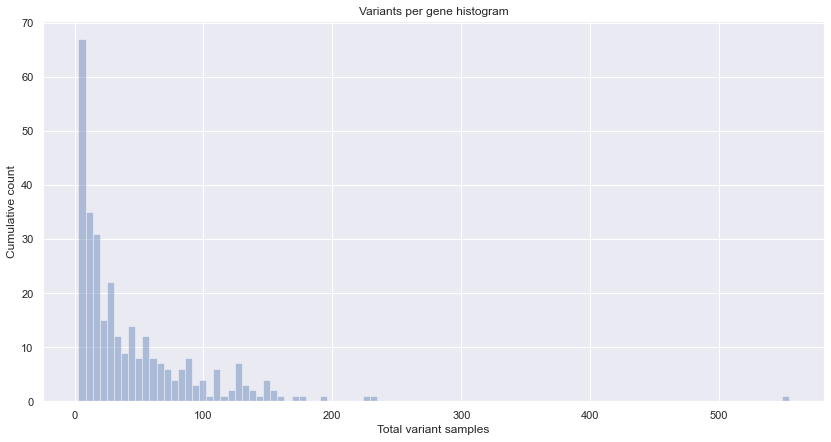

In [11]:
f, axes = plt.subplots(figsize=(14, 7))
ax1 = sns.distplot(significant_genes.total_pos, norm_hist=False, kde=False, bins=100)
ax1.set_title("Variants per gene histogram")
ax1.set_ylabel("Cumulative count")
ax1.set_xlabel("Total variant samples")

print(f"Total significant genes: {significant_genes.shape[0]}", file=sys.stderr)
print(f"{significant_genes[significant_genes.total_pos < 5].shape[0]} genes with <10 variant samples", file=sys.stderr)
print(f"{significant_genes[significant_genes.total_pos < 10].shape[0]} genes with <10 variant samples", file=sys.stderr)
print(f"{significant_genes[significant_genes.total_pos < 25].shape[0]} genes with <25 variant samples", file=sys.stderr)
print(f"{significant_genes[significant_genes.total_pos < 50].shape[0]} genes with <50 variant samples", file=sys.stderr)
print(f"{significant_genes[significant_genes.total_pos < 100].shape[0]} genes with <100 variant samples", file=sys.stderr)

Viewing this as a cumulative plot, we can see that ~50% of all genes have fewer than 25 samples with variants (both cases and controls).

p-value show a much more uniform distribution

C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Cumulative frequency')

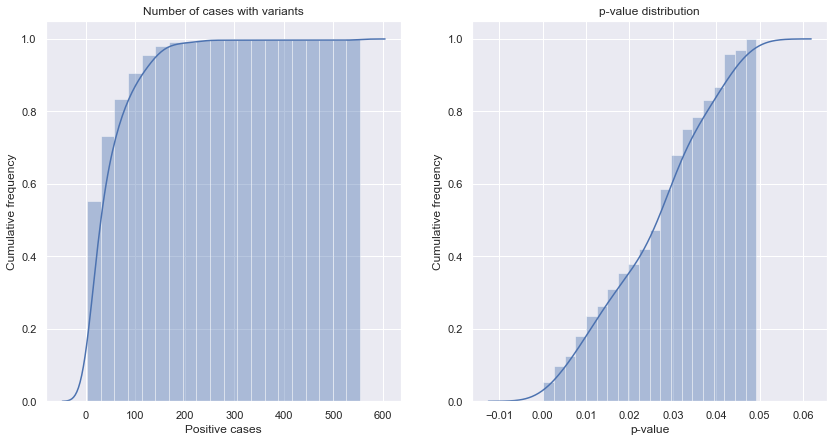

In [12]:
f, axes = plt.subplots(1, 2, figsize=(14, 7))

kwargs = {'cumulative': True}
ax1 = sns.distplot(significant_genes.total_pos, hist_kws=kwargs, kde_kws=kwargs, ax=axes[0], bins=20)
ax1.set_title("Number of cases with variants")
ax1.set_xlabel("Positive cases")
ax1.set_ylabel("Cumulative frequency")
ax2 = sns.distplot(significant_genes.pval, hist_kws=kwargs, kde_kws=kwargs, ax=axes[1], bins=20)
ax2.set_title("p-value distribution")
ax2.set_xlabel("p-value")
ax2.set_ylabel("Cumulative frequency")

We can see both the total number of positive samples and the p value distributions together with a density plot:

**I'm not really sure that this is a useful plot, it was just satisfying to make...**

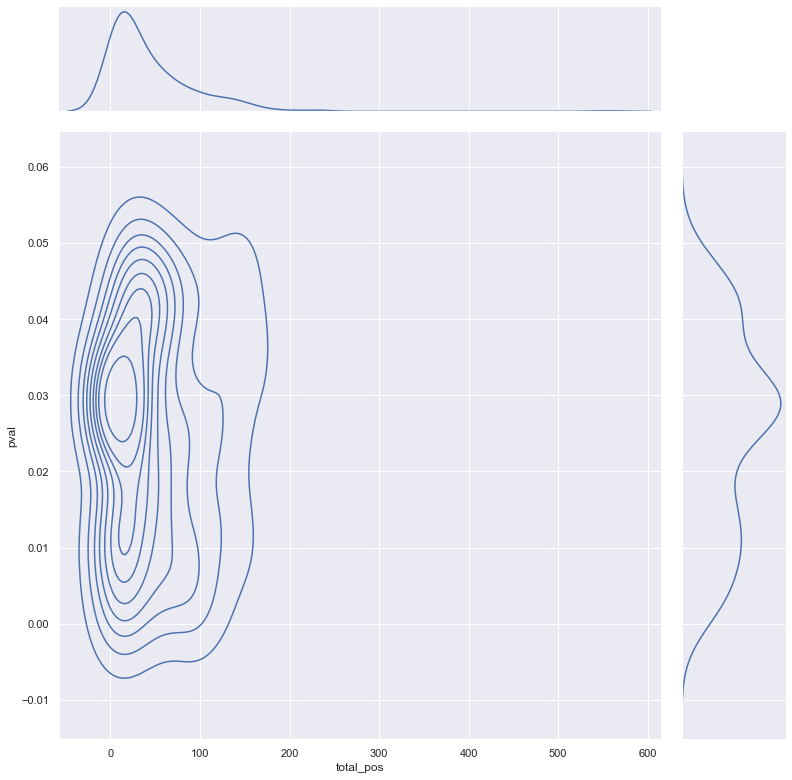

In [13]:
sns.jointplot(x=significant_genes.total_pos, y=significant_genes.pval, kind='kde', height=11)

## ?? enrichment analysis

Can we see if there are any particular pathways enriched in our list of significant genes?

In [14]:
minsamples = 25
filtered_genes = significant_genes[significant_genes.total_pos >= minsamples].sort_values("pval")

print(f"Using a minimum cutoff of {minsamples} samples with variants, {filtered_genes.shape[0]} significant genes remain", file=sys.stderr)
print(f"Total genes: {burden_test.shape[0]}", file=sys.stderr)

Using a minimum cutoff of 25 samples with variants, 162 significant genes remain
Total genes: 17794


In [15]:
# It might just be quicker (and easier!) to manually correct any genes flagged as not recognised by Panther
# NOPE - full reference list has 658 unrecognised IDs, so that's too many to update manually.

import requests
import time

# Check genes against HGNC database
def get_latest_symbol_from_hgnc(symbol: str) -> str:
    """
    https://wrgl-resources.herokuapp.com/API/genes-transcripts/gene-name/<symbol>
    """
    endpoint= "https://wrgl-resources.herokuapp.com/API/genes-transcripts/gene-name"
    query = f"{endpoint}/{symbol}"
    try:
        data = requests.get(query).json()
        if data['hgnc_id'] is not None:
            return (data['hgnc_id'])
        return symbol
    except:
        print(f"ERROR: Something went wrong checking HGNC for {symbol}", file=sys.stderr)
        return symbol
    
# Add chromosome to df for manahattan plot
def get_chromosome(hgnc: str) -> str:
    """
    Get the
    """
    headers = {'Accept': 'application/json'}
    endpoint = "http://rest.genenames.org/fetch/hgnc_id"
    query = f"{endpoint}/{hgnc}"
    if "HGNC" in hgnc:
        try:
            data = requests.get(query, headers=headers).json()
            location = data['response']['docs'][0]['location']
            locationp = location.split('p')
            locationq = location.split('q')
            if len(locationp) > len(locationq):
                return locationp[0]
            else:
                return locationq[0]
            return location
        except:
            print(f"ERROR: Something went wrong checking HGNC for gene {hgnc}", file=sys.stderr)
            return "None"
    else:
        print(f"ERROR: gene {hgnc} does not have an HGNC ID", file=sys.stderr)
        return None

In [16]:
%%time

# Load the smaller trimmed dataframe if it's available
try:
    hgnc_checked = pd.read_pickle("Processed_data/hgnc_checked.pickle")
    print("Loaded HGNC checked data from file.", file=sys.stderr)
except FileNotFoundError:
    # Load the processed data from the previous step
    hgnc_checked = burden_test
    hgnc_checked['HGNC'] = hgnc_checked.GENE.map(get_latest_symbol_from_hgnc)
    # Drop any genes without HGNC IDs
    hgnc_checked = hgnc_checked.dropna()
    # Find the chromsome
    hgnc_checked['CHROM'] = hgnc_checked.HGNC.map(get_chromosome)
    # Add the log10 of the pval
    hgnc_checked['logp'] = -np.log10(hgnc_checked['pval'])
    # Chromosome order (for ordered categorical data type)
    chromorder = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10",
              "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "X"]
    # Set CHROM as ordered categorical, so that the Manhattan plot knows the correct
    hgnc_checked['CHROM'] = hgnc_checked['CHROM'].astype(pd.CategoricalDtype(chromorder, ordered=True))
    # Write processed data to Pickle.
    hgnc_checked.to_pickle("Processed_data/hgnc_checked.pickle")
    print("Checked gene symbols against HGNC IDs, and saved processed data.", file=sys.stderr)

Wall time: 313 ms


Loaded HGNC checked data from file.


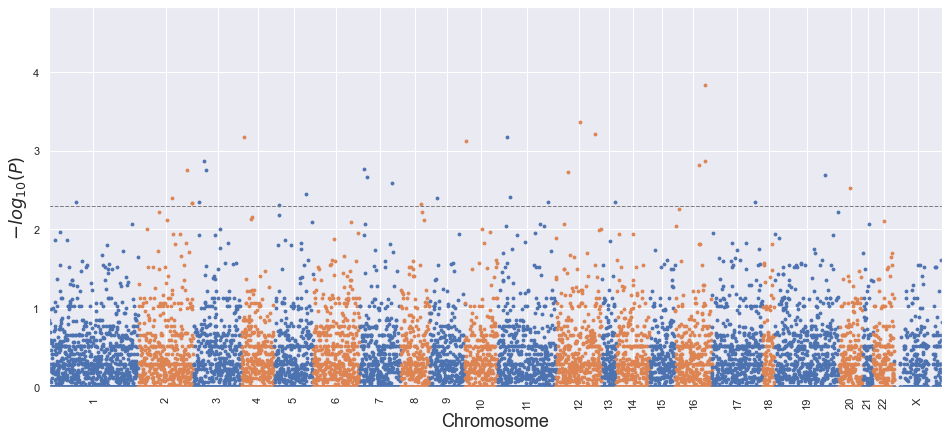

Current p-value threshold = 0.005 gives 30 significant genes.


In [17]:
# Manhattan plot

# WE need to make CHROM an ordered categorical data type
#hgnc_checked['CHROM'] = hgnc_checked['CHROM'].astype(pd.CategoricalDtype(chromorder, ordered=True))

from bioinfokit import analys, visuz

color = (sns.color_palette()[0], sns.color_palette()[1])
pval_threshold = 0.005
ax1 = visuz.marker.mhat(df=hgnc_checked, chr='CHROM', pv='pval', show=True, dim=(16,7), color=color, gwas_sign_line=True, gwasp=pval_threshold, axlabelfontsize=18, axxlabel="Chromosome")

print(f"Current p-value threshold = {pval_threshold} gives {hgnc_checked[hgnc_checked.pval <= pval_threshold].shape[0]} significant genes.", file=sys.stderr)

There appear to be some overrepresented chromosomes - given that this seems to give a column width based on the number of variants, 19 for example seems to have way more than might be expected. It might be worth double checking the exact kit used.

Above plot uses a module that includes a Manhattan plot, but it was being a bit temperamental. Below is the same data, using a seaborn default swarm plot, which doesn't account for the actual position but just clusters each chromosome together:

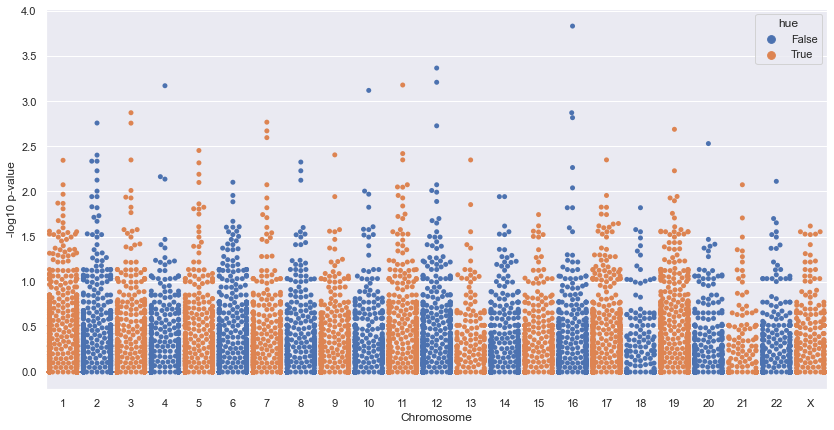

C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


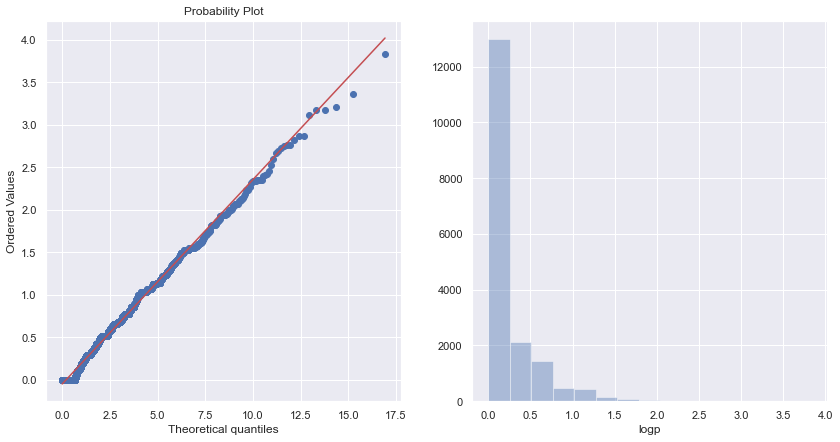

In [18]:
# QQ plot

# Distribution clearly isn't normal - in fact it seems most closely to fit the Chi^2 examples shown at https://www.sciencedirect.com/topics/mathematics/chi-square-distribution
# So use this dist for the QQ plot

# ?? correct number of DoF in this case? Looks like the plot for 1, and fits nicely, but that just feels like a guess...

measurements = hgnc_checked.logp  
f, axes = plt.subplots(1, 2, figsize=(14, 7))
ax1 = stats.probplot(measurements, dist=stats.chi2, sparams=(1,), fit=False, plot=axes[0])
ax2 = sns.distplot(hgnc_checked.logp, ax=axes[1], kde=False, norm_hist=False, bins=15)

In [19]:
# Export lists for Panther

# For now just manually correct any unrecognised gene names

# Reference list (e.g. all genes tested)
hgnc_checked.HGNC.drop_duplicates().to_csv("Processed_data/all_genes.txt", header=False, index=False)

# Significant genes list
hgnc_checked[hgnc_checked.pval <= 0.005].HGNC.drop_duplicates().to_csv("Processed_data/significant_genes.txt", header=False, index=False)

## Additional information that might help

* Coverage information - to help tell if non-variant positions are actually reference or just not covered (and so can't be counted/used)

In [20]:
from tqdm.auto import tqdm
tqdm.pandas()

def get_protein_length(symbol):
    endpoint = "https://wrgl-resources.herokuapp.com/API/genes-transcripts/refseq-transcripts/search-by-gene"
    query = f"{endpoint}/{symbol}"
    data = requests.get(query).json()
    # return the longest protein length value
    try:
        return max([x['prot_length'] for x in data['transcript_list']])
    except:
        return None

# NOTE: This takes a **long** time (>4 hours)
#hgnc_checked['length'] = hgnc_checked.GENE.progress_map(get_protein_length)

C:\Users\ben\anaconda3\envs\mat-effect-genes\lib\site-packages\tqdm\std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [21]:
hgnc_checked.to_pickle("Processed_data/hgnc_with_length.pickle")

In [22]:
hgnc_checked['pos_total'] = hgnc_checked['pos_cases'] + hgnc_checked['pos_controls']
hgnc_checked.sort_values("logp", ascending=False).head()

GENE  total_controls  pos_controls  neg_controls  total_cases  \
7385     INO80E             516             1           515          226   
5204    FAM186A             516            54           462          226   
12001     PRIM1             516             6           510          226   
10673    OR51J1             516             5           511          226   
6949   HSD17B13             516            50           466          226   

       pos_cases  neg_cases      pval        HGNC CHROM      logp     tpval  \
7385           9        217  0.000148  HGNC:26905    16  3.830135  3.830135   
5204          46        180  0.000431  HGNC:26980    12  3.365386  3.365386   
12001         13        213  0.000619   HGNC:9369    12  3.208001  3.208001   
10673         12        214  0.000664  HGNC:14856    11  3.177619  3.177619   
6949          43        183  0.000677  HGNC:18685     4  3.169728  3.169728   

       length  pos_total  
7385    244.0         10  
5204   2351.0        100  
12001   420.0         19  
10673   316.0         17  
6949    300.0         93

<AxesSubplot:xlabel='length', ylabel='pos_total'>

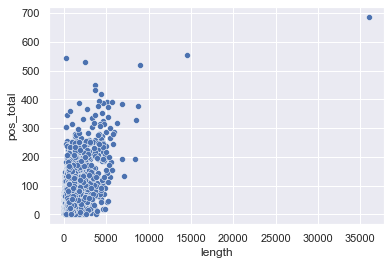

In [23]:
sns.scatterplot(x=hgnc_checked.length, y=hgnc_checked.pos_total)

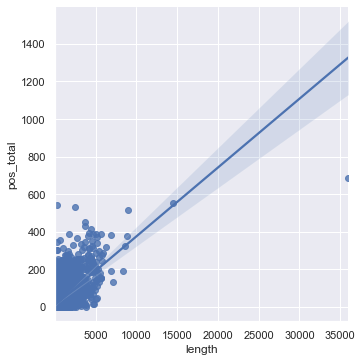

In [24]:
sns.lmplot(data=hgnc_checked, x="length", y="pos_total")

## Examining variants

Now we need to take a look at the variants in the most significant genes, to ensure that they are consistent with causing a phenotypic effect - that is they largely appear to be likely deleterious. If all the variants are strongly predicted to have no impact (although at this stage they all cause protein-coding changes), then we may need to alter the filtering strategy used to select the variant counts used for burden testing (e.g. by filtering on CADD score if it can be added, or maybe Condel)

In [25]:
# Load the full variant data
df_variants = pd.read_pickle("Data/variant_phenotype_merged.pickle")

# Remove duplicates and unwanted information (e.g. patient-level stuff that we don't want because this isn't sample-specific)
print(f"Total variants: {df_variants.shape[0]}", file=sys.stderr)
df_variants = df_variants.drop_duplicates(subset="ID")

print(f"De-duplicated variants: {df_variants.shape[0]}", file=sys.stderr)
df_variants = df_variants[["CHROM", "POS", "ID", "GENE", "IMPACT", "HGVSc", "HGVSp", "SIFT", "Polyphen", "Condel", "GnomAD_AF", "ExAC_AF"]]

# Get the top 5 most significant genes
top_genes = hgnc_checked.sort_values("logp", ascending=False).head(5)['GENE']

# Extract the variants for these most significant genes
df_variants_filtered = df_variants[df_variants.GENE.isin(top_genes)]
print(f"Variants from significant genes: {df_variants_filtered.shape[0]}", file=sys.stderr)

def extract_class(value):
    """
    Extract the classification of SIFT/Polyphen/Condel
    Whene the classification and score are combined
    e.g. deleterious(0.01)
    """
    try:
        return value.split("(")[0]
    except:
        # If there is no Condel score, then the variant is most likely truncating, and so deleterious
        return "deleterious"

df_variants_filtered["Condel_Class"] = df_variants_filtered['Condel'].apply(extract_class)

# Write to an Excel file
df_variants_filtered.to_excel("Processed_Data/significant_variants.xlsx")

Total variants: 1091589
De-duplicated variants: 167273
Variants from significant genes: 59
<ipython-input-25-661846b11953>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_variants_filtered["Condel_Class"] = df_variants_filtered['Condel'].apply(extract_class)


In [26]:
def get_ref(value):
    """
    Get the reference allele from the ID column
    """
    # Remove the chromosome
    value = value.split(":")[1]
    # remove the alt allele
    value = value.split(">")[0]
    # TODO: Remove the POS
    digits = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    return "".join([x for x in value if x not in digits])

def get_alt(value):
    """
    Get the alt allele from the ID column
    """
    return value.split(">")[1]

def write_line(value, outfile):
    """
    Write the variant to a VCF file
    """
    outfile.write(f"{value['CHROM']}\t{value['POS']}\t.\t{value['REF']}\t{value['ALT']}\t99\tPASS\t.\n")
    return f"{value['CHROM']}\t{value['POS']}\t{value['REF']}\t{value['ALT']}\n"

def write_vcf(target_df, outpath):
    """
    Write the given dataframe to a VCF file for CADD annotation
    """
    temp_vcf = target_df.loc[:,("CHROM", "POS", "ID")]
    temp_vcf["REF"] = temp_vcf['ID'].apply(get_ref)
    temp_vcf["ALT"] = temp_vcf.loc[:,'ID'].apply(get_alt)

    # Write this to VCF format
    with open(outpath, "w") as outfile:
        outfile.write("##fileformat=VCFv4.2\n")
        outfile.write("#CHROM POS ID REF ALT QUAL FILTER INFO\n")
        temp_vcf.sort_values(["CHROM", "POS"]).apply(write_line, args=(outfile,), axis=1)
    
    print(f"Wrote {temp_vcf.shape[0]} variants to VCF file {outfile}.", file=sys.stderr)
    
#write_vcf(df_variants_filtered, "Processed_data/for_Cadd.vcf")

In [27]:
for index, subarray in enumerate(np.array_split(df_variants.sort_values(["CHROM", "POS"]), 5)):
    outpath = f"Processed_data/for_Cadd_pt{index+1}.vcf"
    write_vcf(subarray, outpath)

Wrote 33455 variants to VCF file <_io.TextIOWrapper name='Processed_data/for_Cadd_pt1.vcf' mode='w' encoding='cp1252'>.
Wrote 33455 variants to VCF file <_io.TextIOWrapper name='Processed_data/for_Cadd_pt2.vcf' mode='w' encoding='cp1252'>.
Wrote 33455 variants to VCF file <_io.TextIOWrapper name='Processed_data/for_Cadd_pt3.vcf' mode='w' encoding='cp1252'>.
Wrote 33454 variants to VCF file <_io.TextIOWrapper name='Processed_data/for_Cadd_pt4.vcf' mode='w' encoding='cp1252'>.
Wrote 33454 variants to VCF file <_io.TextIOWrapper name='Processed_data/for_Cadd_pt5.vcf' mode='w' encoding='cp1252'>.


In [28]:
# THIS CAN PROBABLY BE USED FOR MUCH BIGGER SETS?

# Read the CADD score file
temp_cadd = pd.read_csv("Processed_data/with_Cadd_all.tsv", delimiter="\t", skiprows=1)
temp_cadd['ID'] = temp_cadd.apply(lambda x: f"{x['#CHROM']}:{x['POS']}{x['REF']}>{x['ALT']}", axis=1)

# Merge the full data set with the CADD score file
temp_cadd = temp_cadd[['ID', 'PHRED']].set_index("ID")
temp_vcf = df_variants.set_index("ID")
temp_cadd = temp_vcf.join(temp_cadd).reset_index()

# Save to Excel
#temp_cadd.to_excel("Processed_Data/significant_variants.xlsx")

temp_cadd.head()

ID CHROM      POS    GENE    IMPACT                        HGVSc  \
0   1:983604C>T     1   983604    AGRN  MODERATE  ENST00000379370.2:c.3964C>T   
1  1:1266738G>A     1  1266738  TAS1R3  MODERATE    ENST00000339381.5:c.13G>A   
2  1:1267651G>A     1  1267651  TAS1R3  MODERATE   ENST00000339381.5:c.740G>A   
3  1:1269488G>A     1  1269488  TAS1R3  MODERATE  ENST00000339381.5:c.2203G>A   
4  1:1277183C>T     1  1277183    DVL1  MODERATE   ENST00000378891.5:c.469G>A   

                            HGVSp                            SIFT  \
0  ENSP00000368678.2:p.Arg1322Trp                 tolerated(0.21)   
1     ENSP00000344411.5:p.Ala5Thr  tolerated_low_confidence(0.43)   
2   ENSP00000344411.5:p.Arg247His                 tolerated(0.55)   
3   ENSP00000344411.5:p.Ala735Thr                 tolerated(0.13)   
4   ENSP00000368169.5:p.Ala157Thr                 tolerated(0.68)   

        Polyphen          Condel  GnomAD_AF   ExAC_AF   PHRED  
0  benign(0.332)  neutral(0.148)   0.001796  0.001381  13.290  
1  benign(0.021)  neutral(0.014)   0.043690  0.045000   3.850  
2  benign(0.005)  neutral(0.007)   0.025230  0.027000   1.738  
3  benign(0.011)  neutral(0.253)   0.013530  0.015000   9.562  
4      benign(0)  neutral(0.002)   0.014690  0.017000   2.935

In [29]:
temp_cadd.shape

(167273, 13)